# Homework 8: Clustering

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Mall Customers Dataset

In this assignment, you will work on customer segmentation using clustering techniques.

The dataset for this assignment is the **Mall Customers Dataset**, which contains customer data collected from a shopping mall. It includes:

- **CustomerID**: Unique identifier for each customer (not useful for clustering).
- **Gender**: Male or Female.
- **Age**: Age of the customer.
- **Annual Income (k$)**: Annual income in thousands of dollars.
- **Spending Score (1-100)**: A metric indicating customer spending habits.

The goal is to segment customers based on their characteristics using different clustering methods.


In [ ]:
# Install yellowbricks if you don't already have it or are in colab
!pip install yellowbrick

In [ ]:
import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
# Uncomment the line below if you are using Google colab
!gdown https://drive.google.com/uc?id=1Jo9YoLfvey-y6hIQK_pii-XUCJNAE_TE

Downloading...
From: https://drive.google.com/uc?id=1Jo9YoLfvey-y6hIQK_pii-XUCJNAE_TE
To: /content/Mall_Customers.csv
100% 4.29k/4.29k [00:00<00:00, 12.8MB/s]


1. Load the CSV file. Display the summary statistics for the dataset and check if there are any null values in the dataset. Use polars unless your operators do not allow it (transforming them to pandas or numpy at that stage).

In [ ]:
# Load the dataset
data = pl.read_csv('Mall_Customers.csv')
data.describe()

statistic,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",150.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [ ]:
# Code here
data.null_count()

CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
u32,u32,u32,u32,u32
0,0,0,0,0


2. For the clustering analyses, consider only the numerical variables. Therefore you should drop 'Genre' from the dataset. Standardize the remaining variables, ensuring they have mean of zero and standard deviation of one.

In the following lines you should:

- Update the dataset to include only numerical features and display the first 10 rows of the updated dataset.

- Standardize the features.

In [ ]:
data = data.drop(pl.col('Genre'))
data.head(10)

CustomerID,Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64,i64
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
6,22,17,76
7,35,18,6
8,23,18,94
9,64,19,3


In [ ]:
features_to_transform = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create a ColumnTransformer object that scales the features to transform
transform_numbers = ColumnTransformer([('scaler', StandardScaler(), features_to_transform)],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False,
                                      force_int_remainder_cols=False)

data_scaled = transform_numbers.fit_transform(data.drop("CustomerID"))
data_scaled = pl.from_numpy(data_scaled, schema=features_to_transform)
data_scaled = data_scaled.with_columns(pl.Series('CustomerID', data['CustomerID']))
data_scaled.describe()

statistic,Age,Annual Income (k$),Spending Score (1-100),CustomerID
str,f64,f64,f64,f64
"""count""",200.0,200.0,200.0,200.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",-6.3949e-16,-1.4211e-16,-2.1316e-16,100.5
"""std""",1.002509,1.002509,1.002509,57.879185
"""min""",-1.496335,-1.738999,-1.910021,1.0
"""25%""",-0.706902,-0.708425,-0.590088,51.0
"""50%""",-0.204535,0.054964,-0.007764,101.0
"""75%""",0.728432,0.665675,0.885132,150.0
"""max""",2.235532,2.917671,1.894492,200.0


## K-means

3. Use the K-means method to perform clustering on the scaled data from Q2, setting `random_state = 2025`. Determine the optimal number of clusters using the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)  function with `k=(2,12)`.



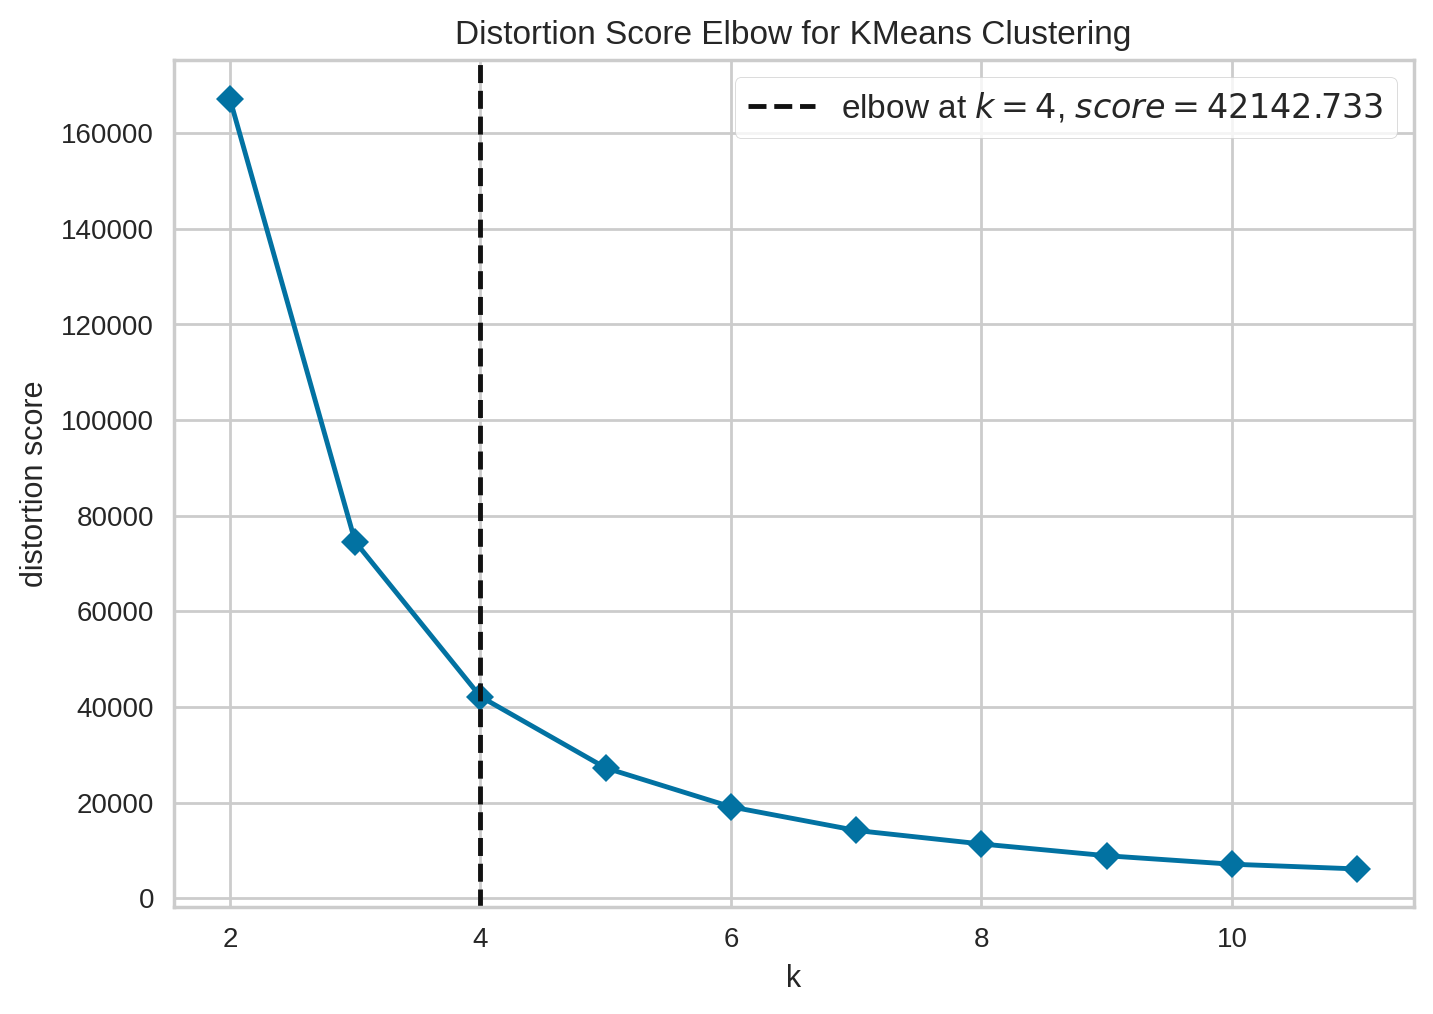

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Find the optimal number of clusters
visualizer = KElbowVisualizer(KMeans(random_state = 2025), # Cluster model with any parameters you need
                              k=(2,12),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=False # Plot the timings to train?
                             )

visualizer.fit(data_scaled.to_numpy())        # Fit the data to the visualizer
visualizer.show()


**Written answer: What is the optimal number of clusters using the elbow method?**

**Written answer:** The optimal number of clusters was found to be four.

4. Fit a K-means model on the scaled data using the optimal number of clusters identified in Q3. Then, visualize the resulting clusters using a scatterplot matrix (`sns.pairplot`).

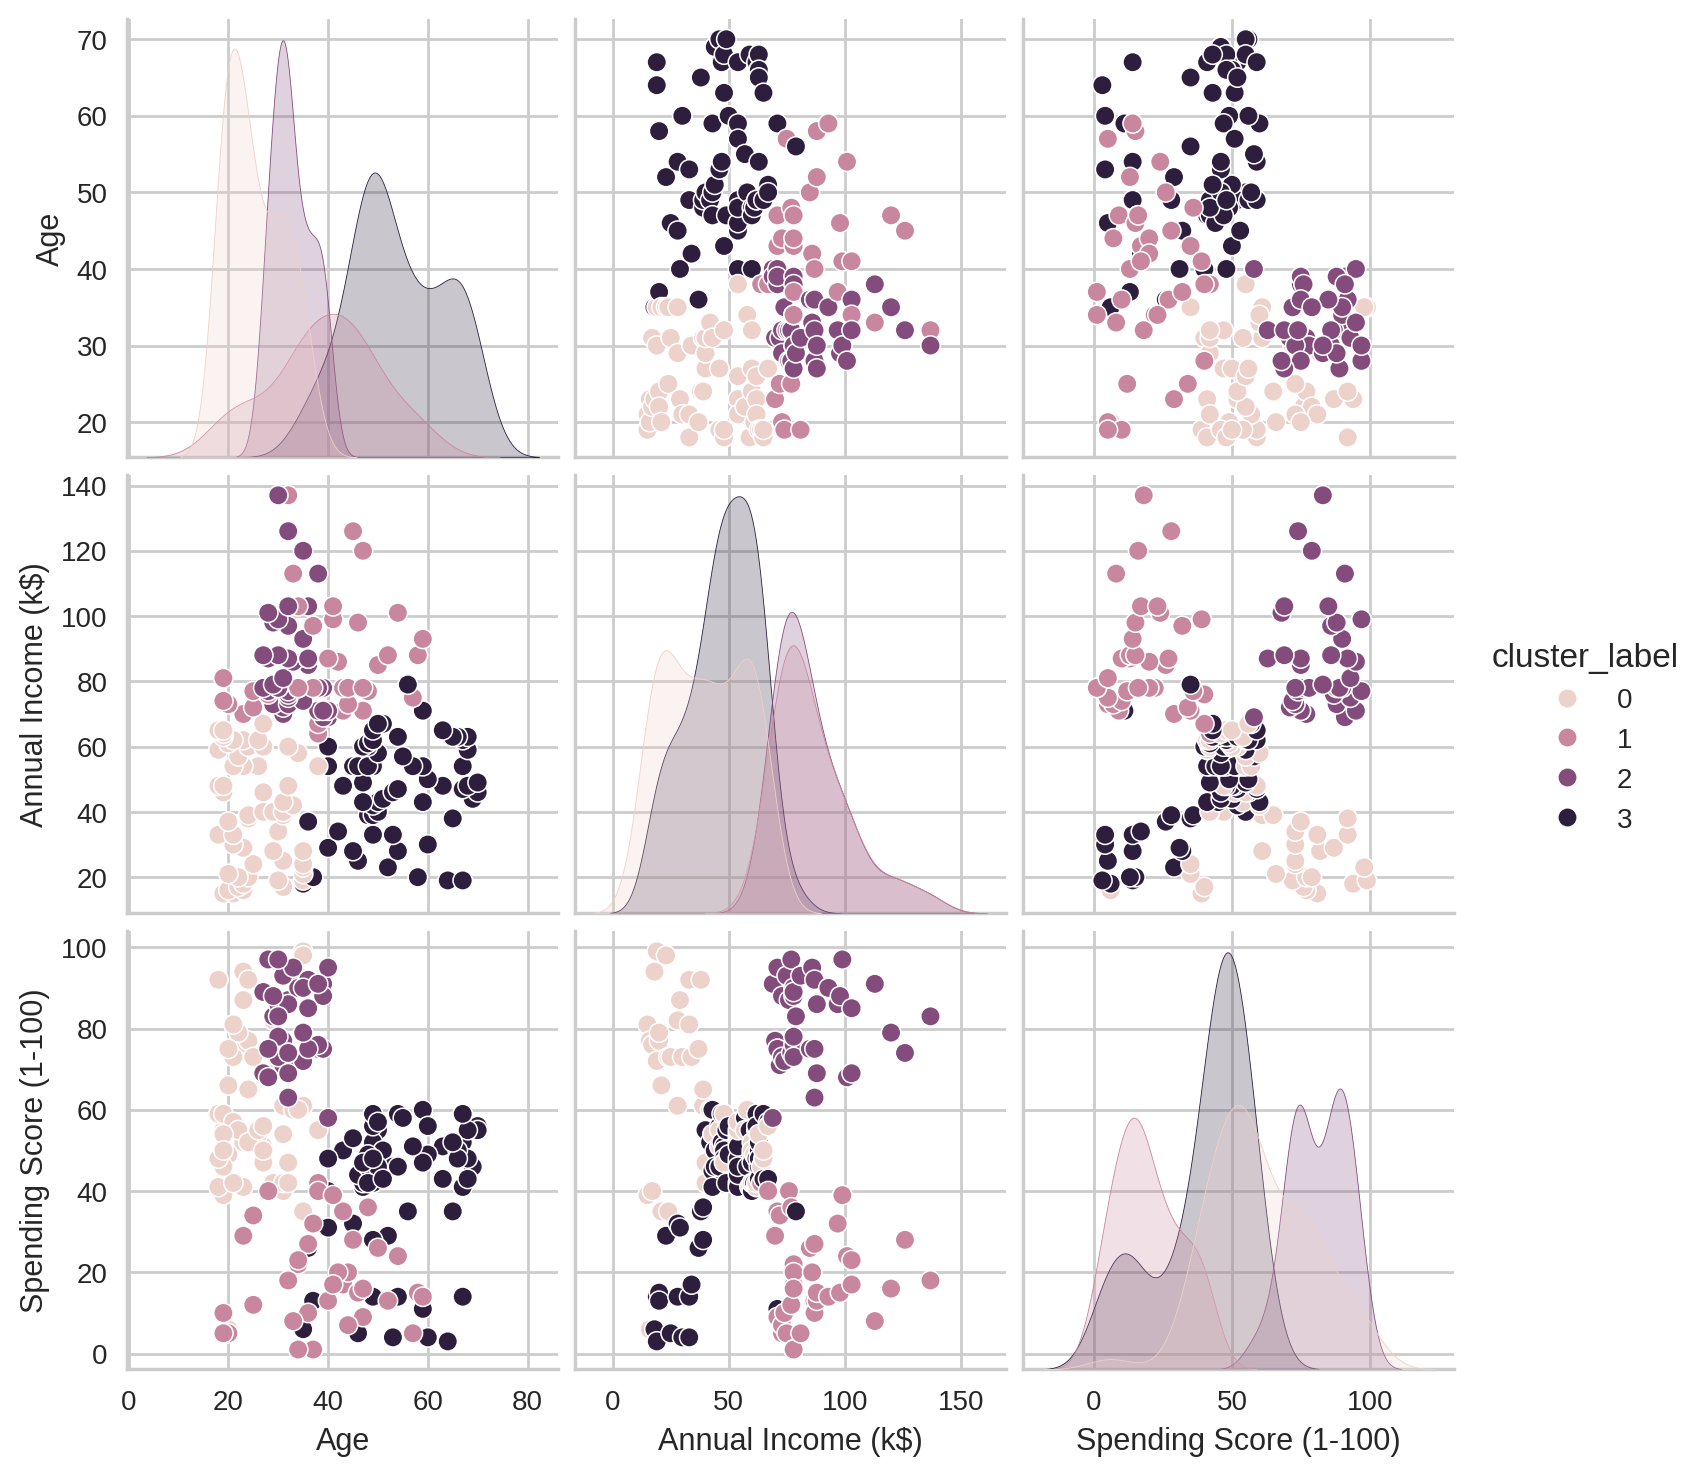

In [ ]:
# Run K-means with the optimal number of clusters to obtain the cluster assignments for each customer
Kmeans_op = KMeans(n_clusters = 4,
                   verbose = 0,
                   random_state = 2025) # Name of operator and cluster number


# Add cluster label to data
data = data.with_columns(pl.Series('cluster_label',
                                   Kmeans_op.fit_predict(data_scaled.drop("CustomerID").to_numpy())
                                   ))

# Create a pairplot using seaborn
sns.pairplot(vars=features_to_transform, # Variable names
             hue='cluster_label',        # How to colour the points. Use cluster labels
             data=data.to_pandas()                   # What data to use
            )

plt.show()

5. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the clusters from Q4, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster by analyzing their defining features, such as whether they represent high-income spenders, budget-conscious customers, or younger versus older groups.

In [ ]:
# Calculate mean of all variables per cluster
data.group_by(by='cluster_label').agg(pl.col(features_to_transform).mean())

by,Age,Annual Income (k$),Spending Score (1-100)
i32,f64,f64,f64
3,53.984615,47.707692,39.969231
1,39.368421,86.5,19.578947
2,32.875,86.1,81.525
0,25.438596,40.0,60.298246


**Written answer:**
1. Cluster 0 represent the youngest customers with the lowest annual income, and a comparatively high spending score.
2. Cluster 1 represents middle-aged customers with the highest income and a low score.
3. Cluster 2 are adults in their low thirties, relatively high income, and the highest spending score.
4. Cluster 3 are, comparatevely, seniors with an average income and a low spending score.


## Agglomerative clustering

6. Use Agglomerative Clustering with `linkage='average'` to determine the best number of clusters (between 3 and 7) using silhouette analysis.

For each number of clusters:

- Compute and print the average silhouette score.
- Generate and display a silhouette plot.

For n_clusters = 3 The average silhouette_score is : 0.3400
For n_clusters = 4 The average silhouette_score is : 0.3839
For n_clusters = 5 The average silhouette_score is : 0.4096
For n_clusters = 6 The average silhouette_score is : 0.3896
For n_clusters = 7 The average silhouette_score is : 0.3800


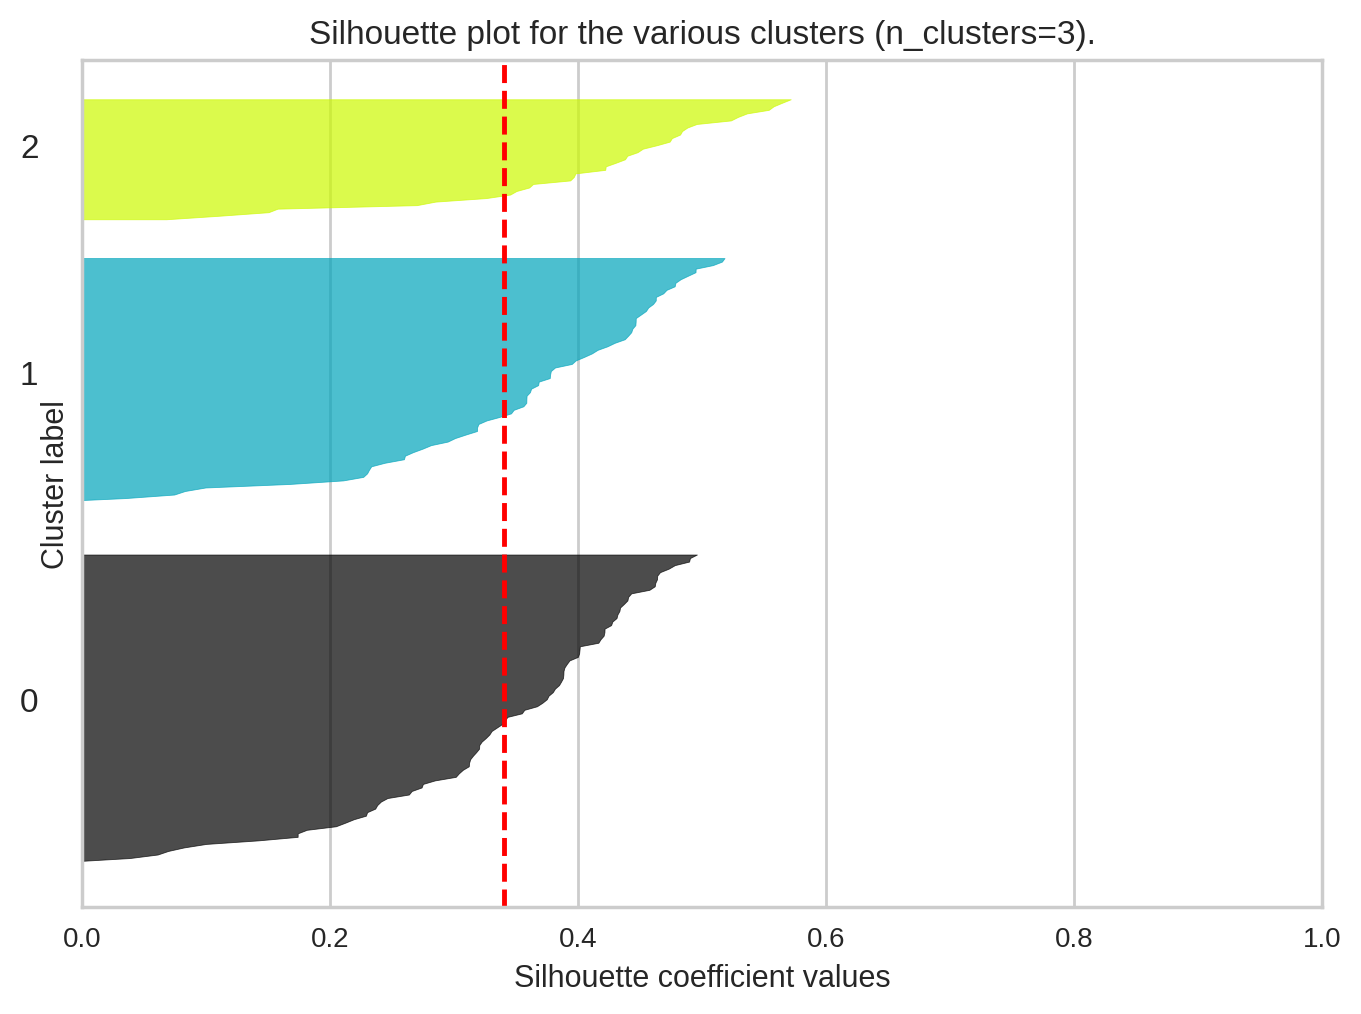

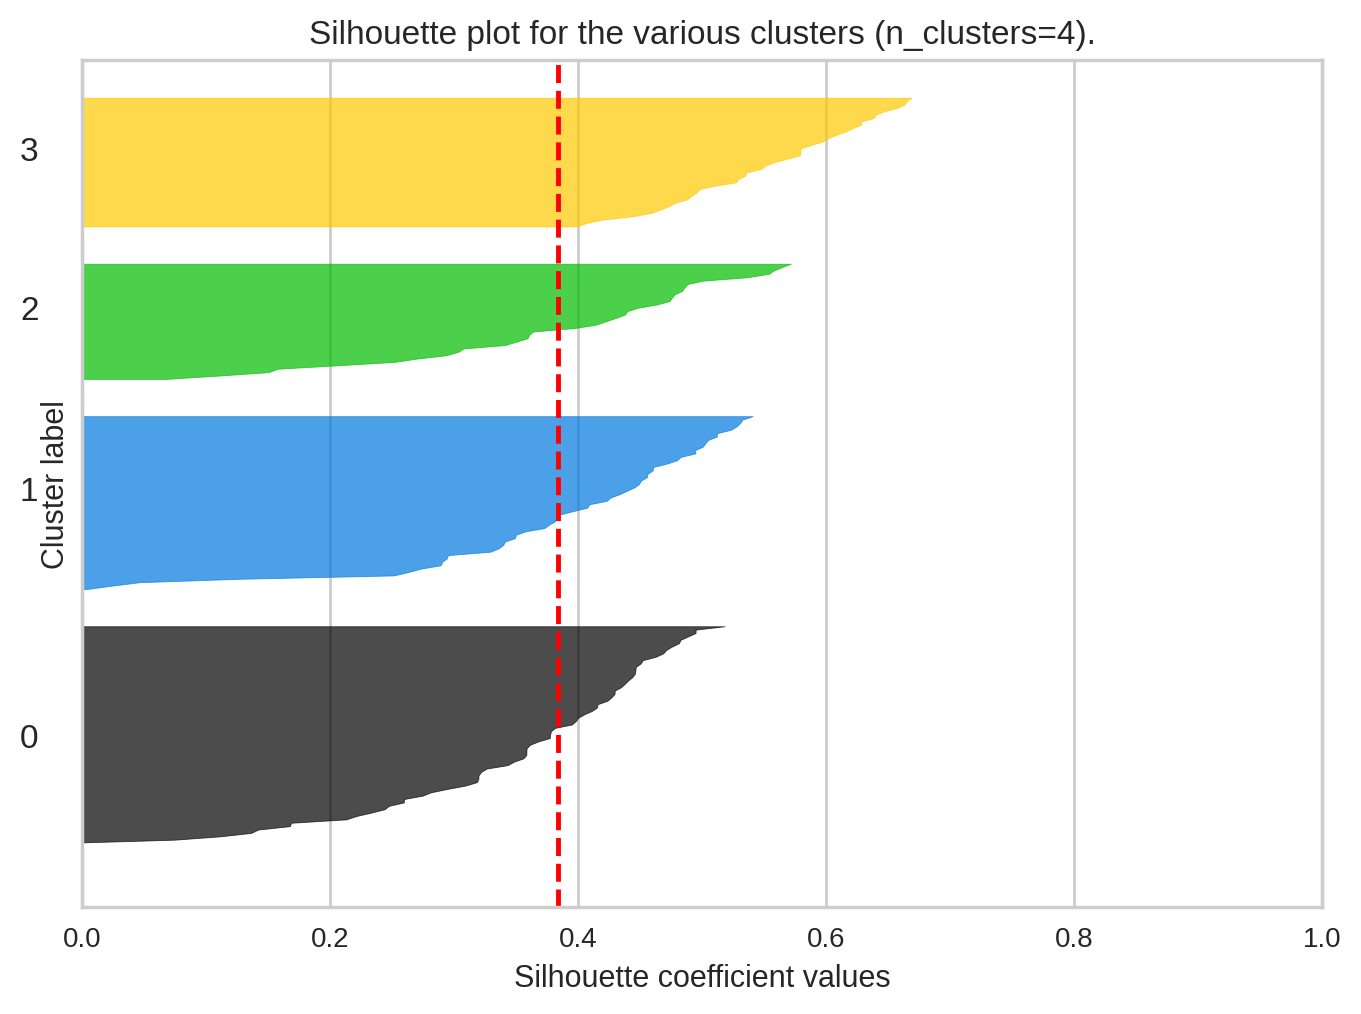

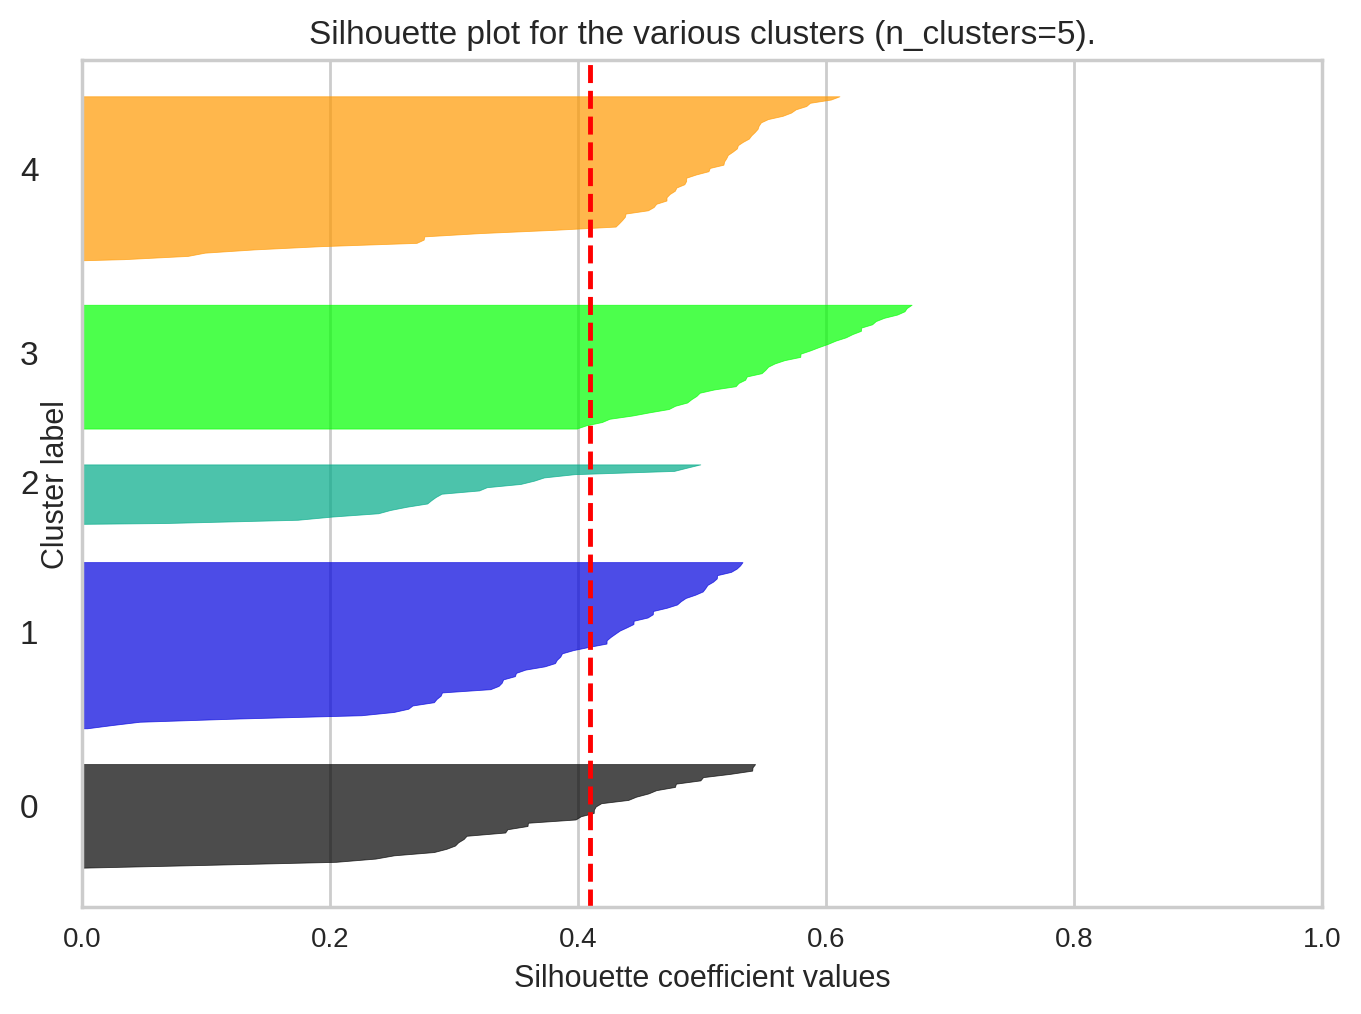

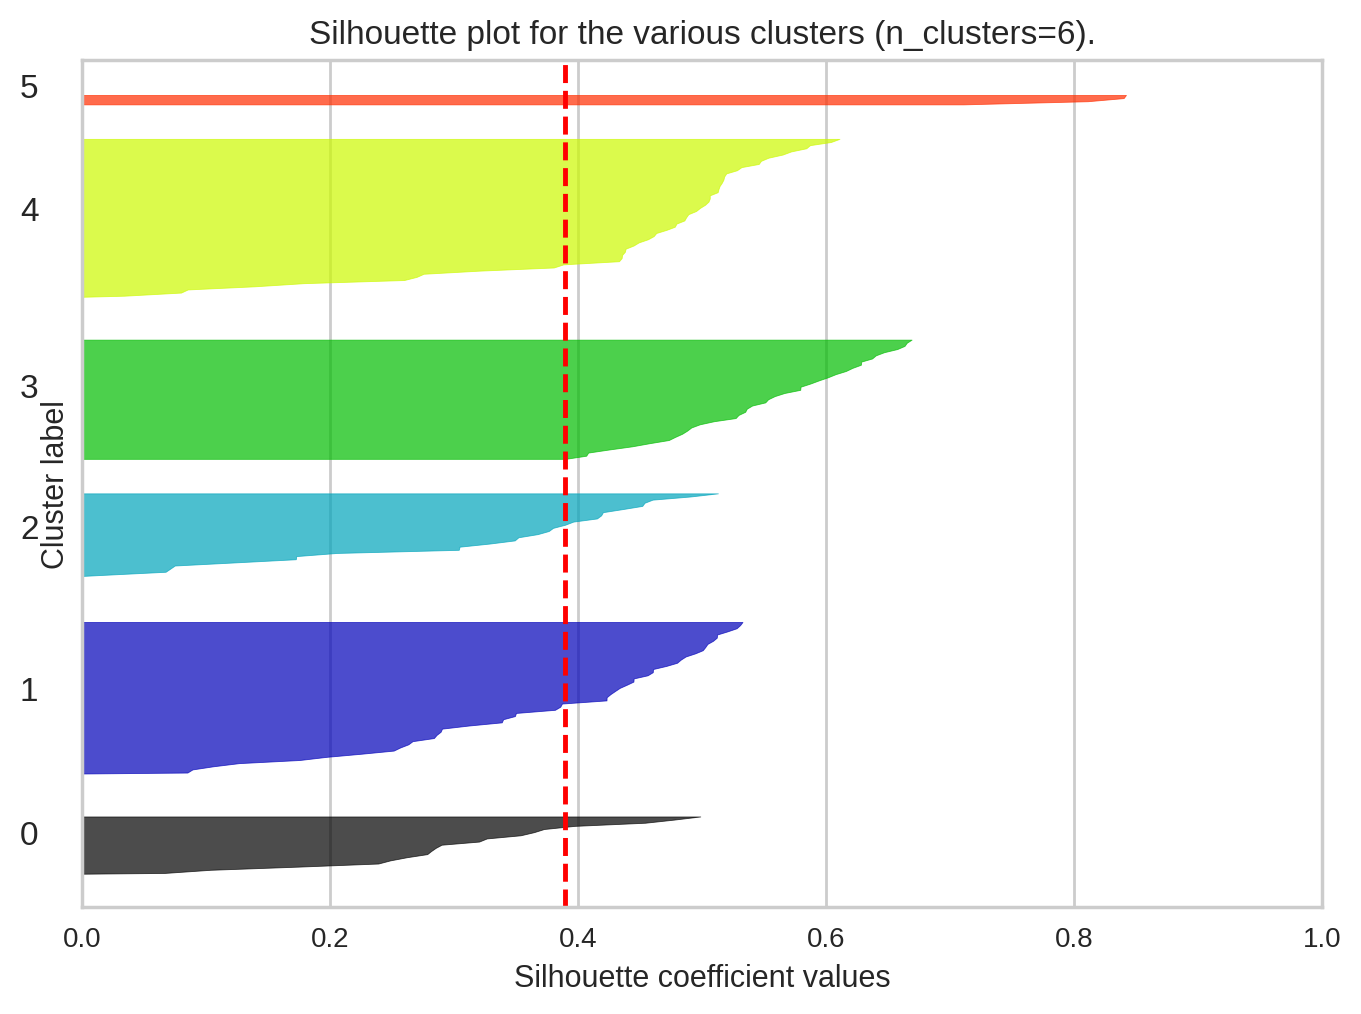

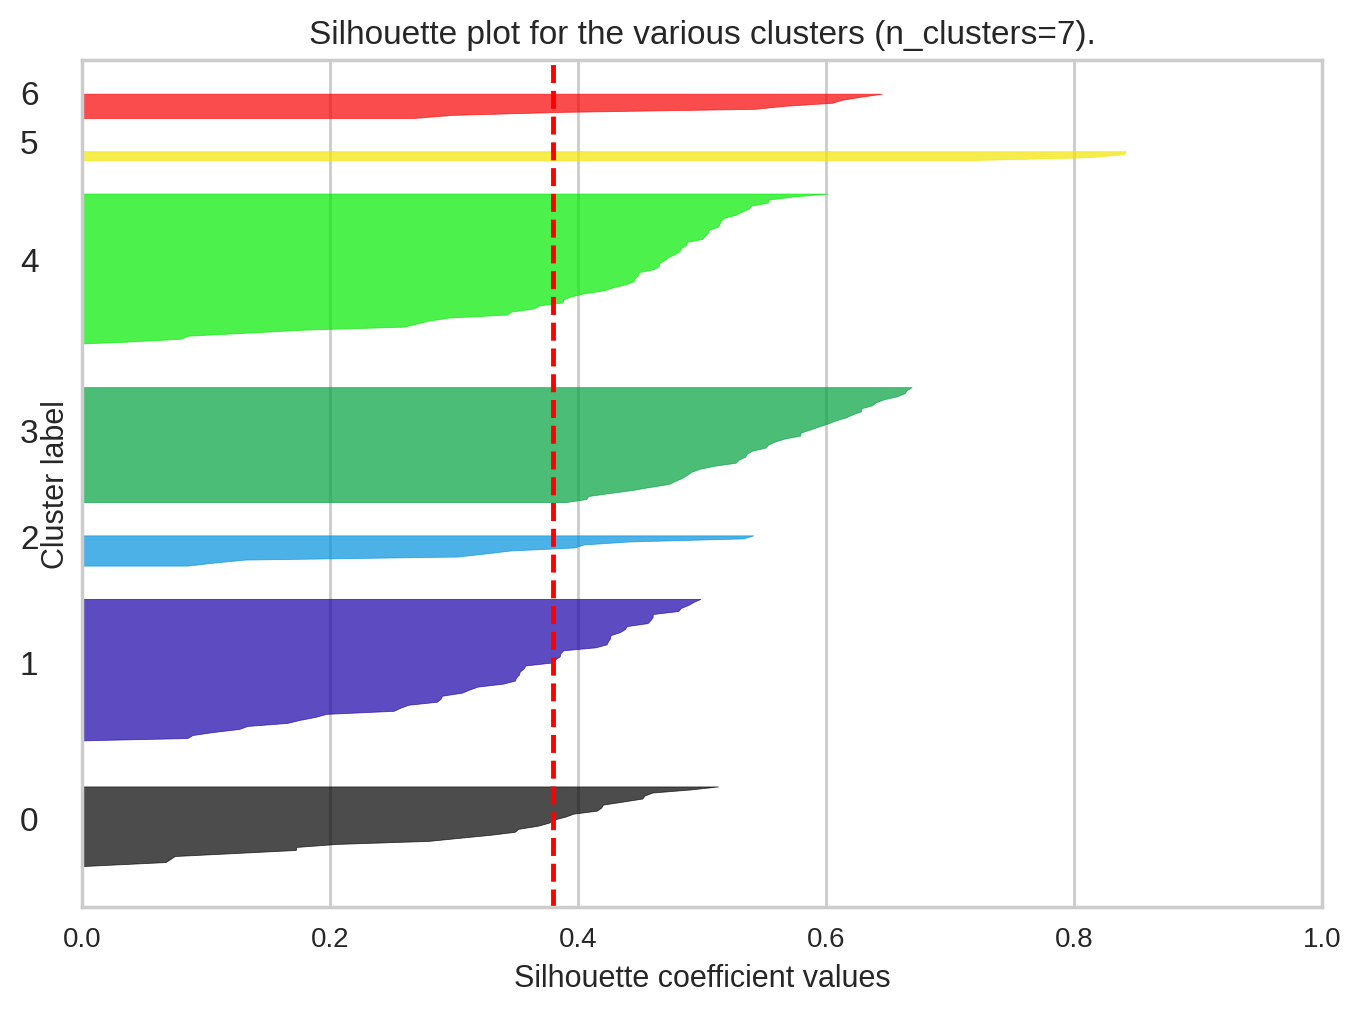

In [ ]:
range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 1 column
        fig, ax1 = plt.subplots(1, 1)

        # The 1st subplot is the silhouette plot
        ax1.set_xlim([0, 1])
        # The (n_clusters + 1) * 10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value
        clusterer = AgglomerativeClustering(n_clusters = n_clusters, # Number of clusters
                                         linkage = "average" # Type of linkage.
                                        )

        cluster_labels = clusterer.fit_predict(data_scaled.drop("CustomerID"))

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(data_scaled.drop("CustomerID"), cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is : %.4f"  % silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_scaled.drop("CustomerID"), cluster_labels)

        y_lower = 10

        # Iterate over the clusters
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor = color, edgecolor = color, alpha = 0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for the various clusters (n_clusters=%i)." % (n_clusters))
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

**Written answer:** In this case the optimal number of clusters is either 4 or 5, with the areas in Silhouette plot for each cluster have similar width. As with 5 clusters the average silhouette score is the maximum, we go with that number.

7. Fit the Agglomerative clustering on the scaled data using the optimal number of clusters identified in Q6. Then, visualize the resulting clusters using scatterplots.

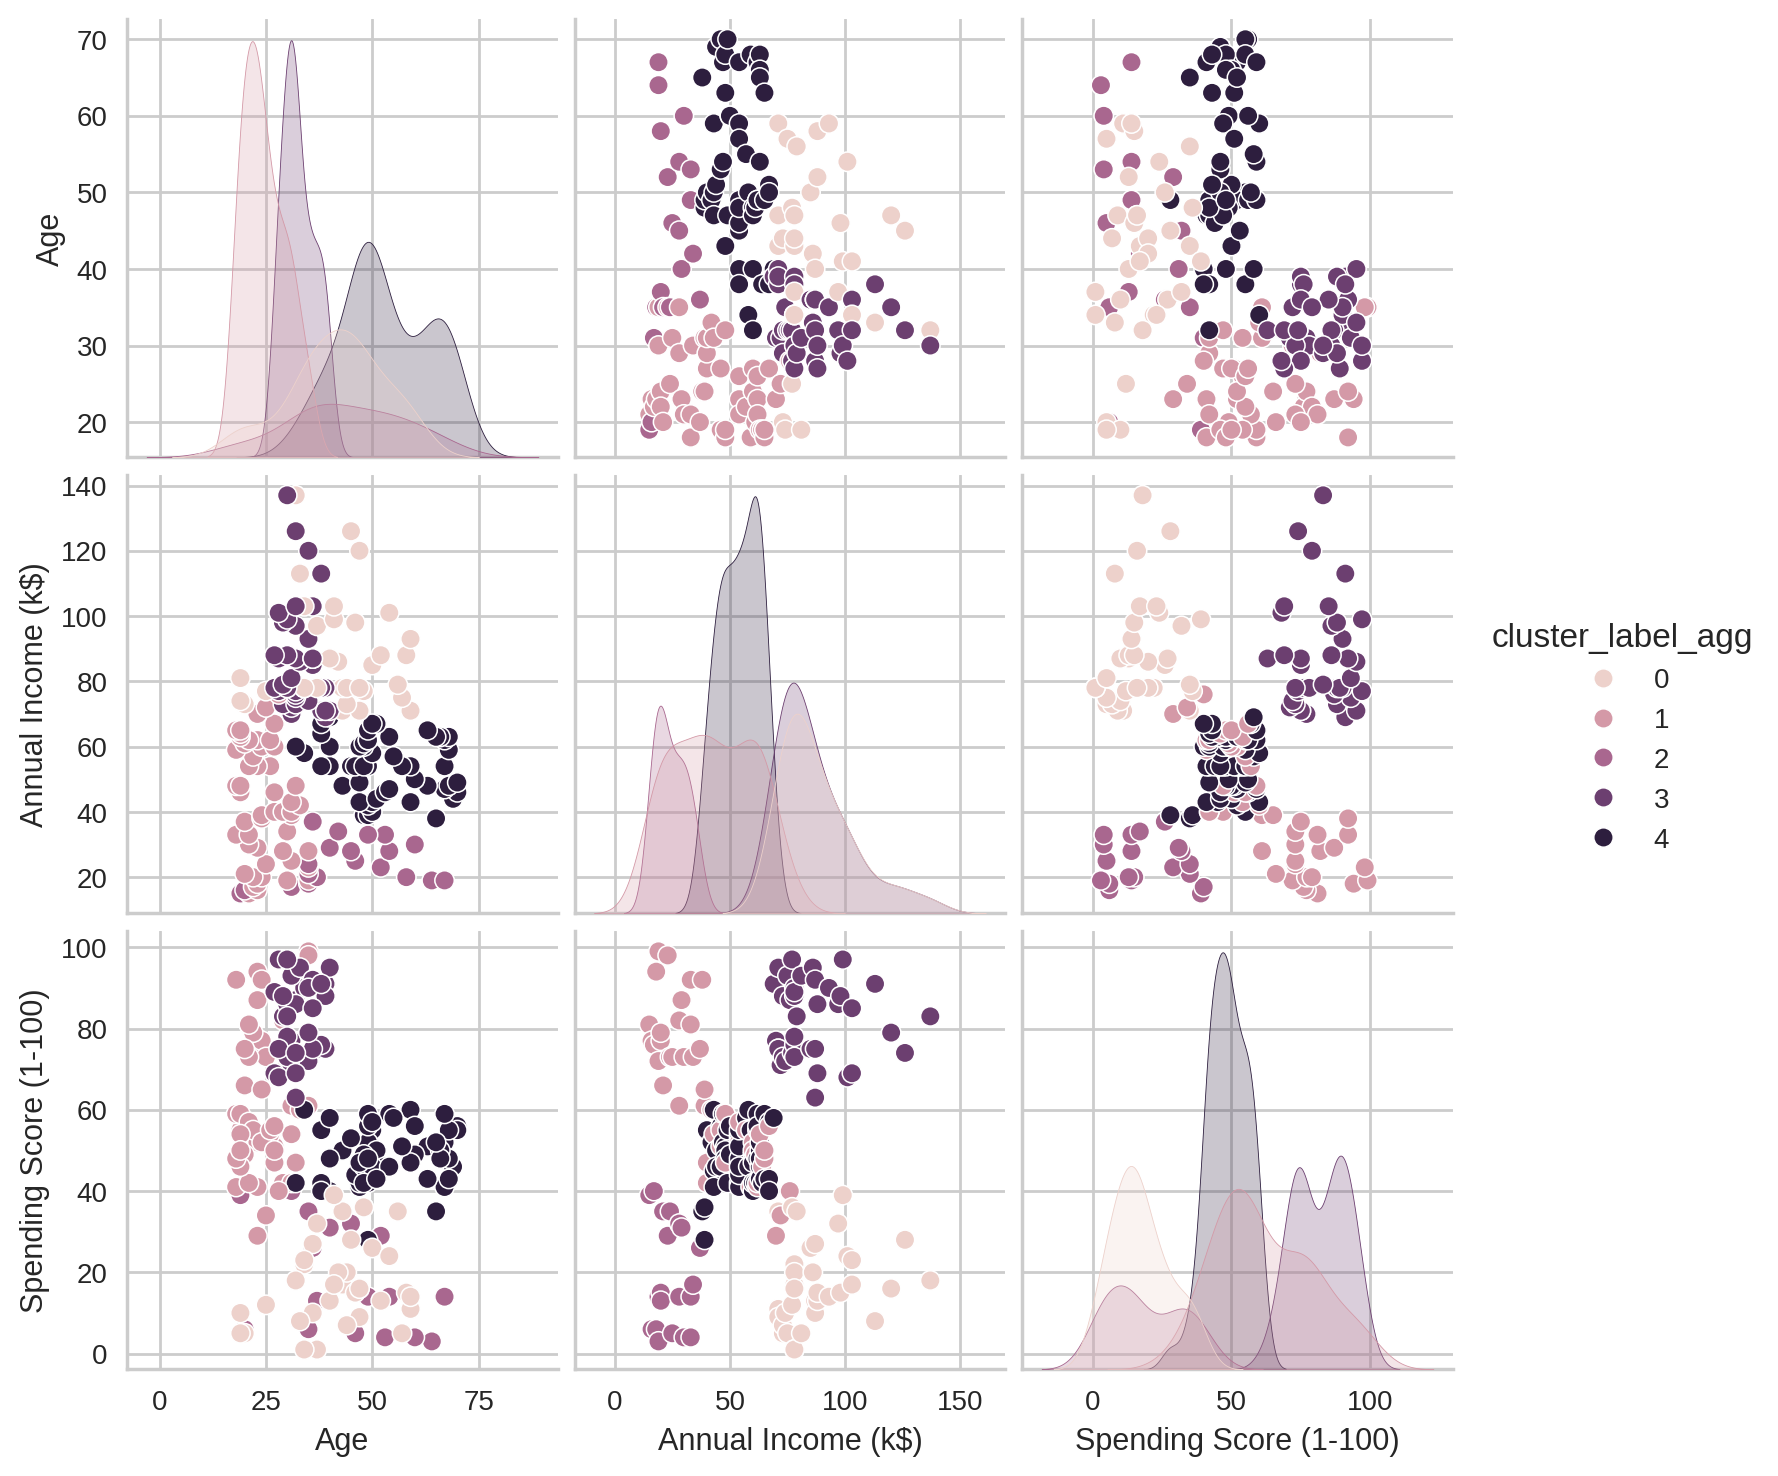

In [ ]:
clusterer = AgglomerativeClustering(n_clusters = 5, # Number of clusters
                                         linkage = "average" # Type of linkage.
                                        )

data = data.with_columns(pl.Series('cluster_label_agg', clusterer.fit_predict(data_scaled.drop("CustomerID"))))

# Create a pairplot using seaborn
sns.pairplot(vars=features_to_transform, # Variable names
             hue='cluster_label_agg',        # How to colour the points. Use cluster labels
             data=data.drop("cluster_label").to_pandas()                   # What data to use
            )

plt.show()


8. Using the clusters from Q7, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [ ]:
data.group_by(by='cluster_label_agg').agg(pl.col(features_to_transform).mean())

by,Age,Annual Income (k$),Spending Score (1-100)
i64,f64,f64,f64
4,53.259259,54.203704,48.555556
0,41.685714,88.228571,17.285714
2,43.9,24.45,19.1
1,24.653846,42.942308,62.076923
3,32.692308,86.538462,82.128205


**Written answer:**

**Written answer:**
1. Cluster 0 represent customers in their low forties with the highest annual income, and lowest spending score.
2. Cluster 1 represents the youngest customers with an average income and a high spending score score.
3. Cluster 2 are adults in their mid forties with lowest income and low spending score.
4. Cluster 3 are, comparatevely, middle-aged customers with high income and the highest spending score
5. Cluster 4 are seniors with an average income and an average spending score.


## Spectral Clustering

9. Use Spectral Clustering to determine the best number of clusters (between 3 and 8) using silhouette analysis.

Set the parameters:
- `affinity = 'nearest_neighbors'`
- `n_jobs = -1`
- `n_neighbors = 10`
- `random_state = 2025`


For each number of clusters:

- Compute and display the average silhouette score
- Generate the silhouette plot.



For n_clusters = 3 The average silhouette_score is : 0.3492
For n_clusters = 4 The average silhouette_score is : 0.3823
For n_clusters = 5 The average silhouette_score is : 0.3428
For n_clusters = 6 The average silhouette_score is : 0.3912
For n_clusters = 7 The average silhouette_score is : 0.4102
For n_clusters = 8 The average silhouette_score is : 0.3614


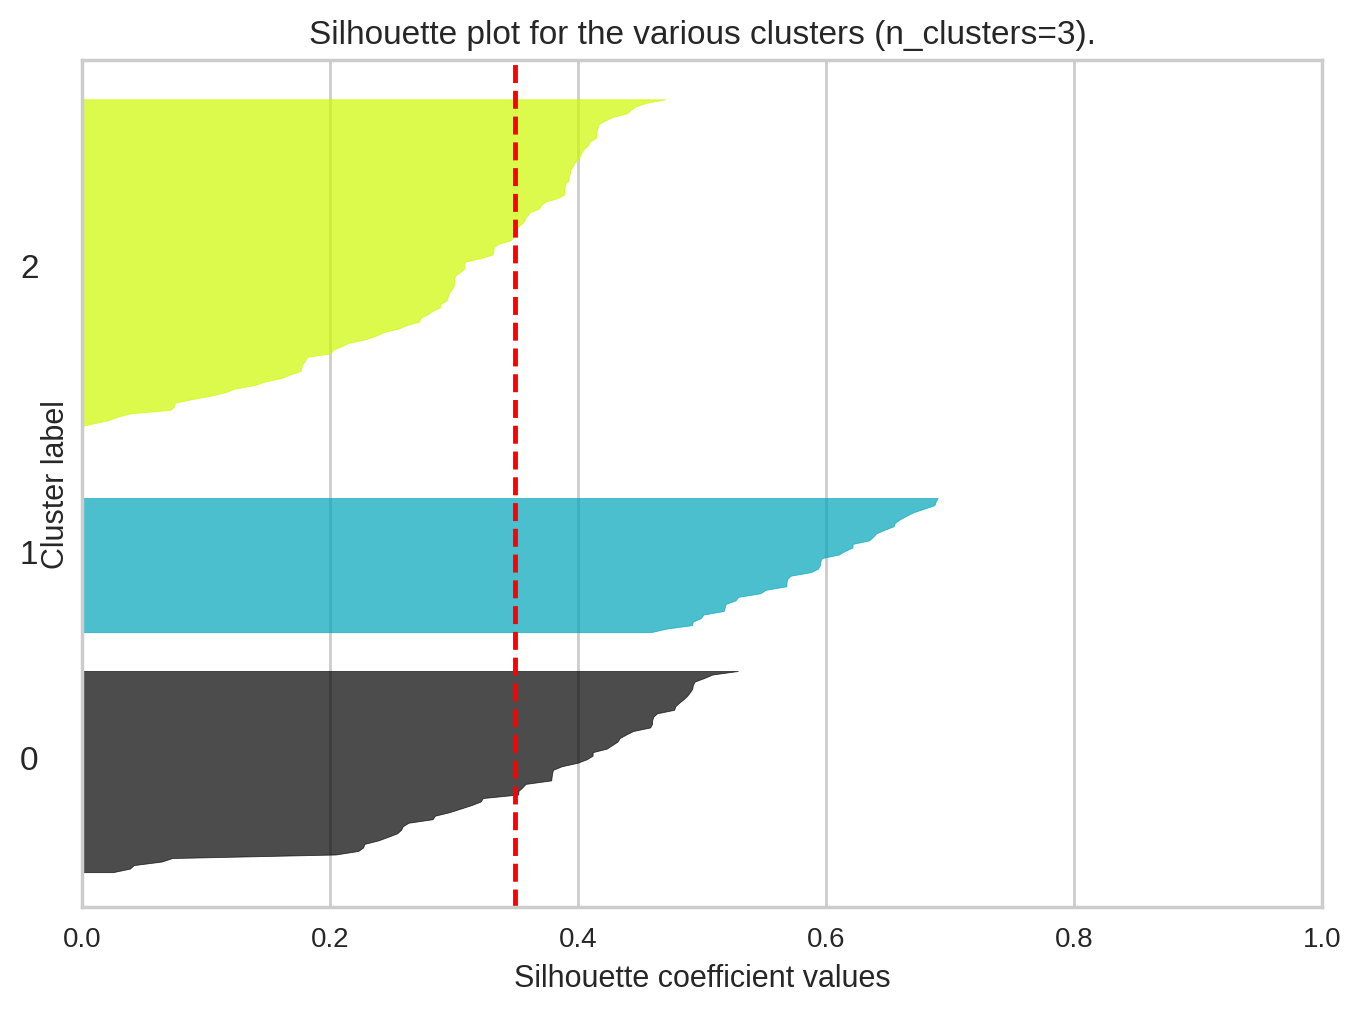

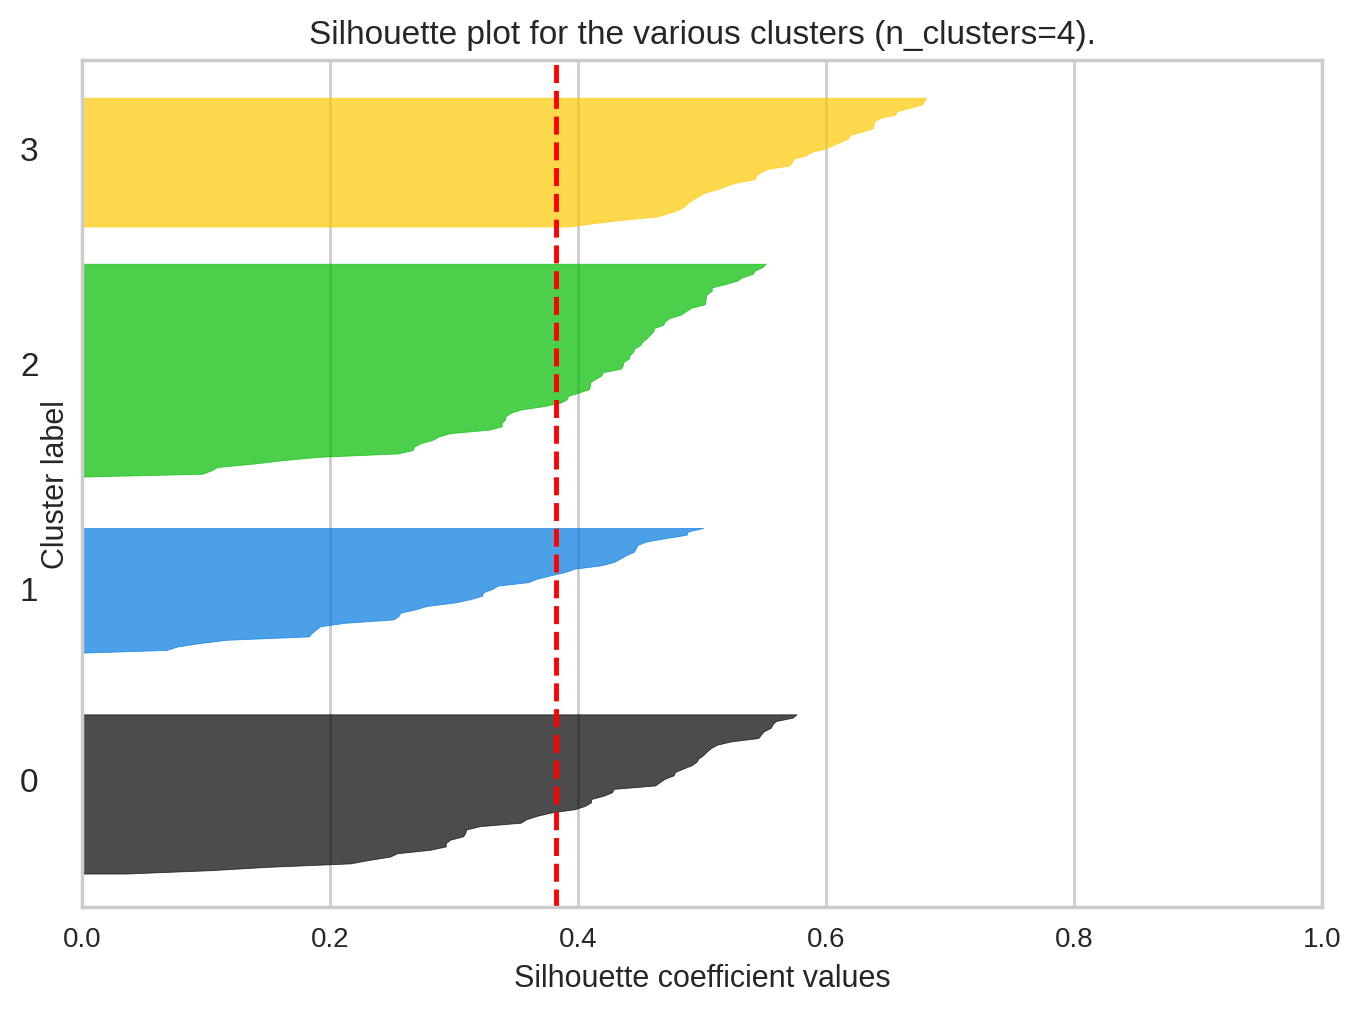

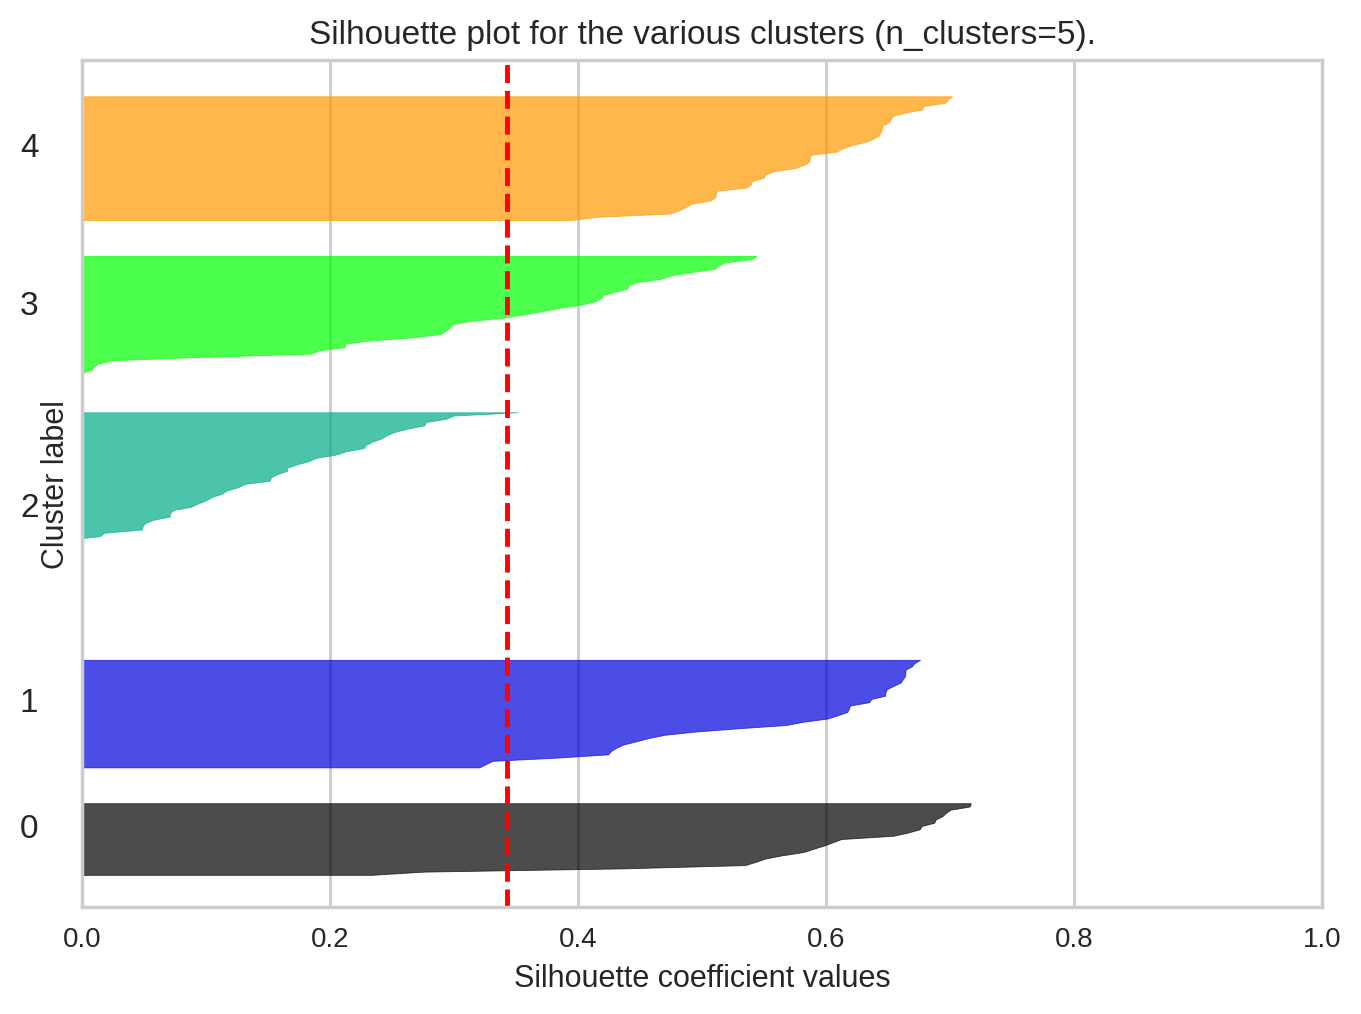

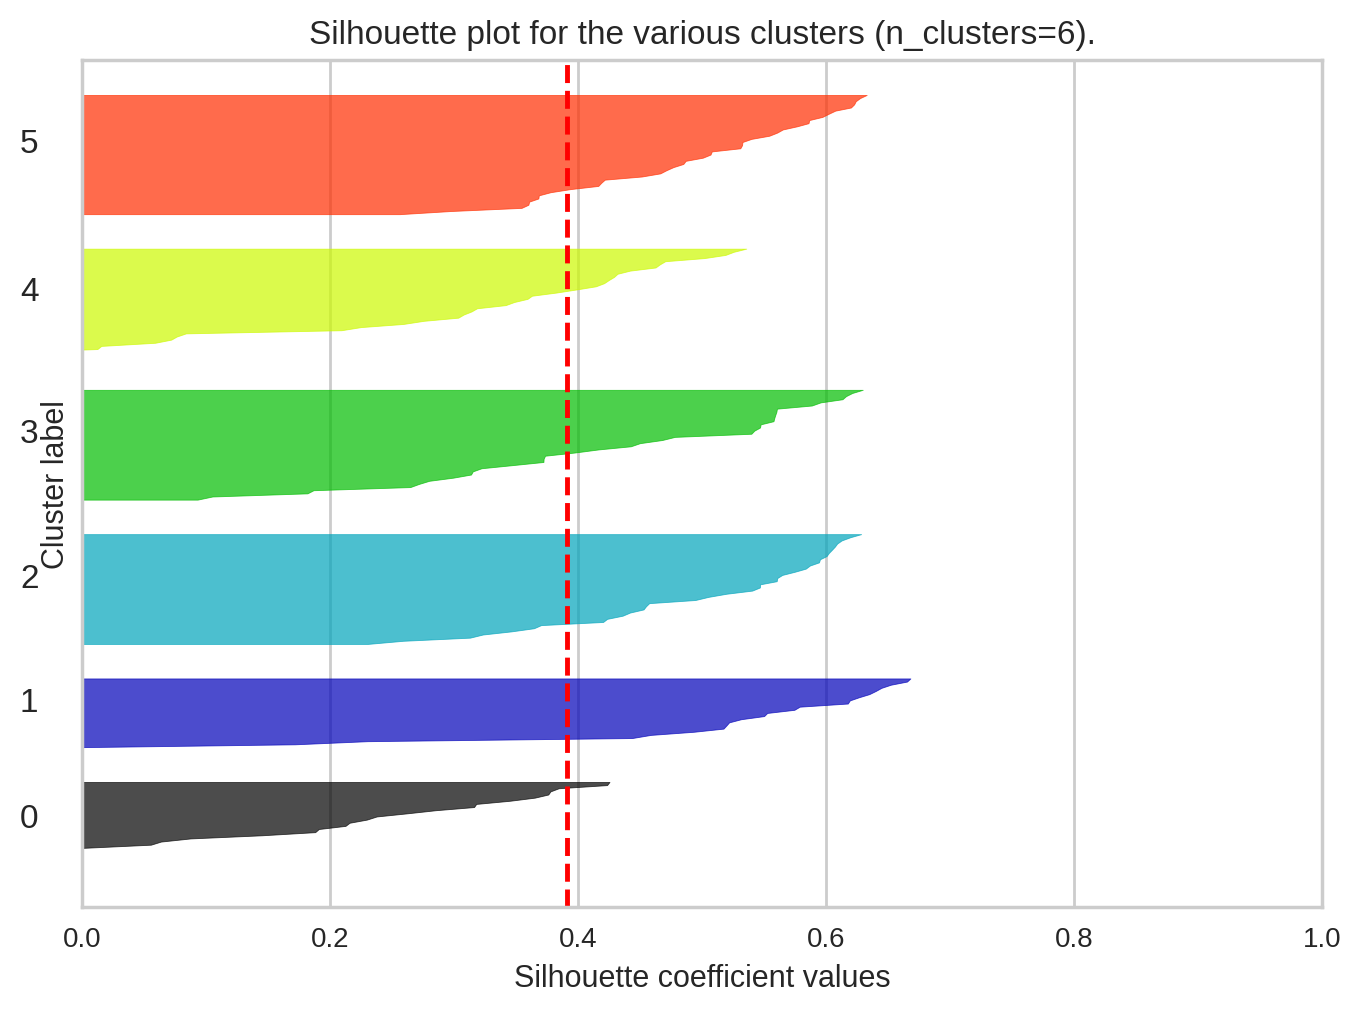

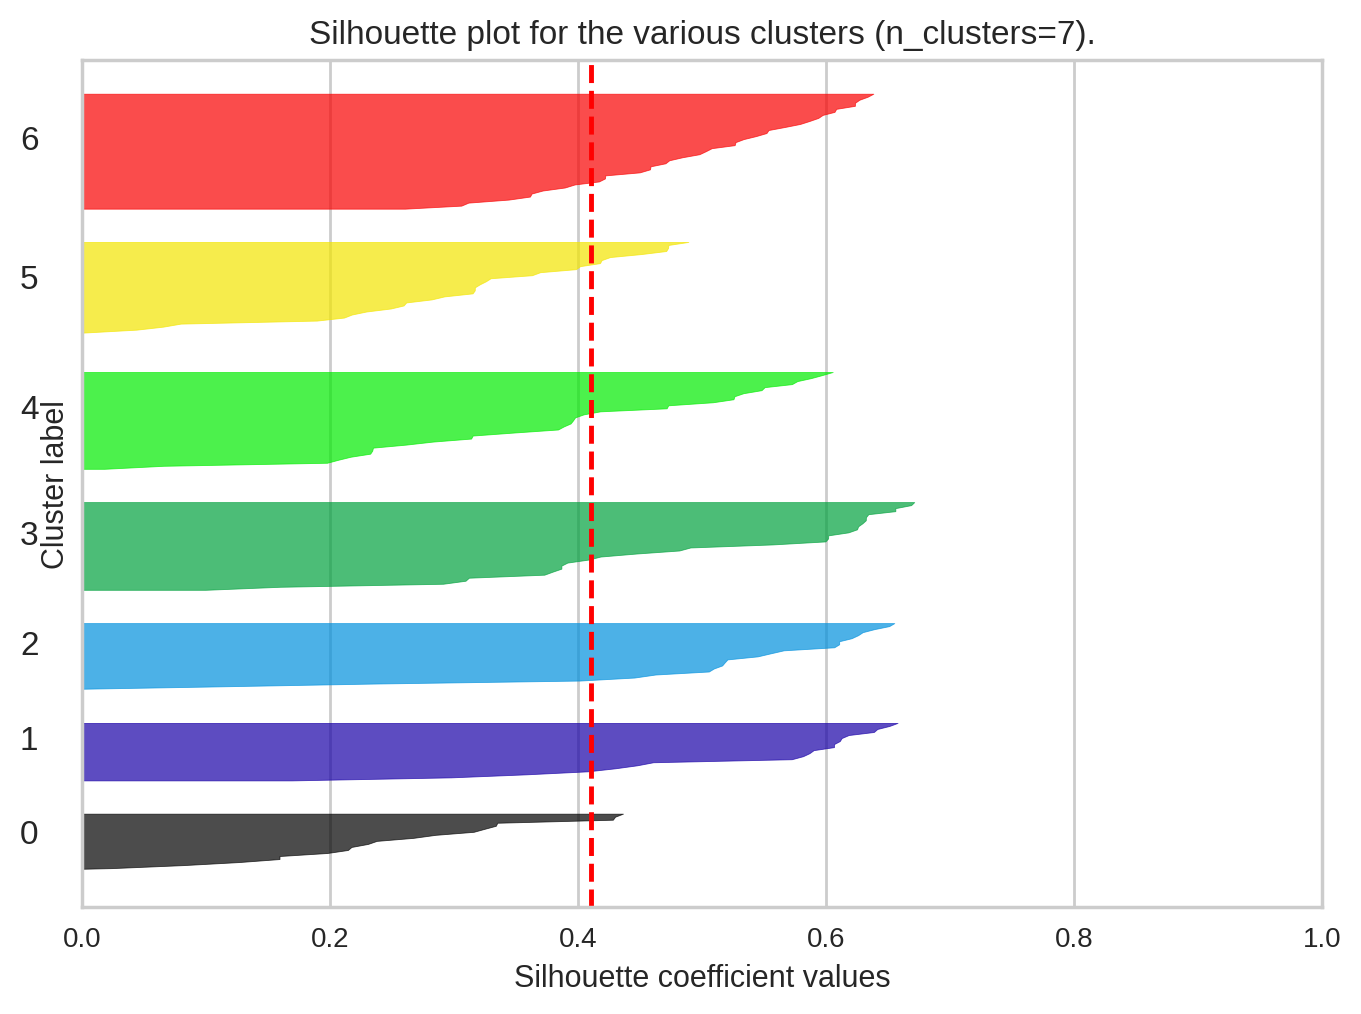

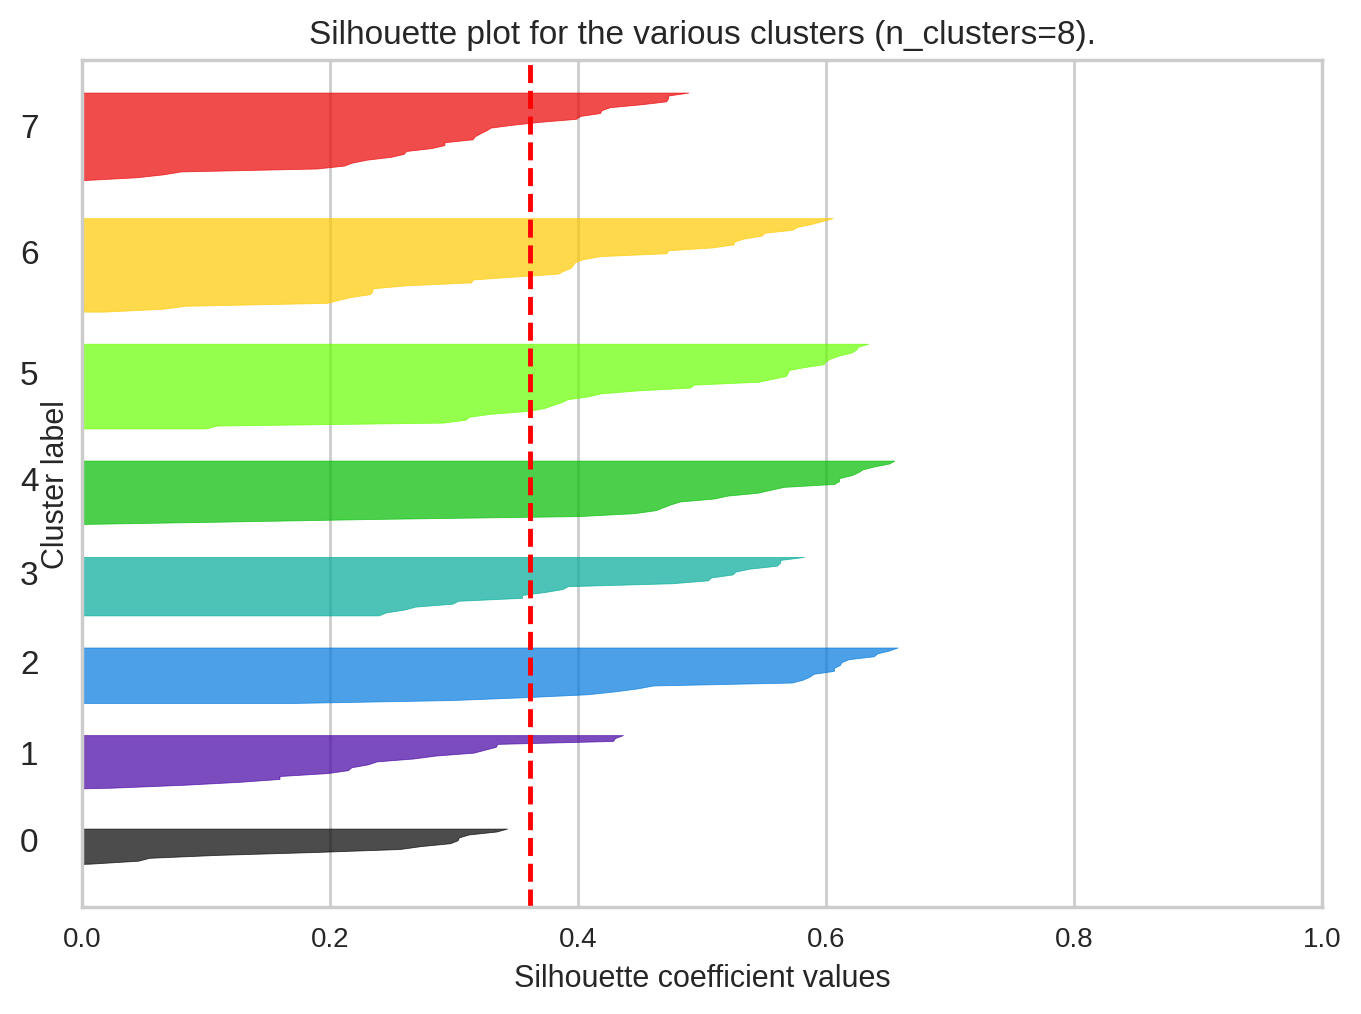

In [ ]:
range_n_clusters = [3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 1 columns
        fig, ax1 = plt.subplots(1, 1)

        # The 1st subplot is the silhouette plot
        ax1.set_xlim([0, 1])
        # The (n_clusters + 1) * 10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value
        spectral_model = SpectralClustering(n_clusters= n_clusters,  # Number of clusters to train.
                                    assign_labels='cluster_qr',
                                    affinity='nearest_neighbors',
                                    n_jobs=-1,
                                    n_neighbors=10,
                                    random_state=2025)

        cluster_labels = spectral_model.fit_predict(data_scaled.drop("CustomerID"))

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(data_scaled.drop("CustomerID"), cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is : %.4f"  % silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_scaled.drop("CustomerID"), cluster_labels)

        y_lower = 10

        # Iterate over the clusters
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor = color, edgecolor = color, alpha = 0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for the various clusters (n_clusters=%i)." % (n_clusters))
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

**Written answer:** the silhouette plot shows the maximum value at 7 clusters. However, at 6 and 4 there are also good clusterings. Following the fact that all clusters must be around the mean, we select 4, although choosing six or eight could be argued.

10. Fit a Spectral Clustering on the scaled data using the optimal number of clusters identified in Q9. Then, visualize the resulting clusters using scatterplots.

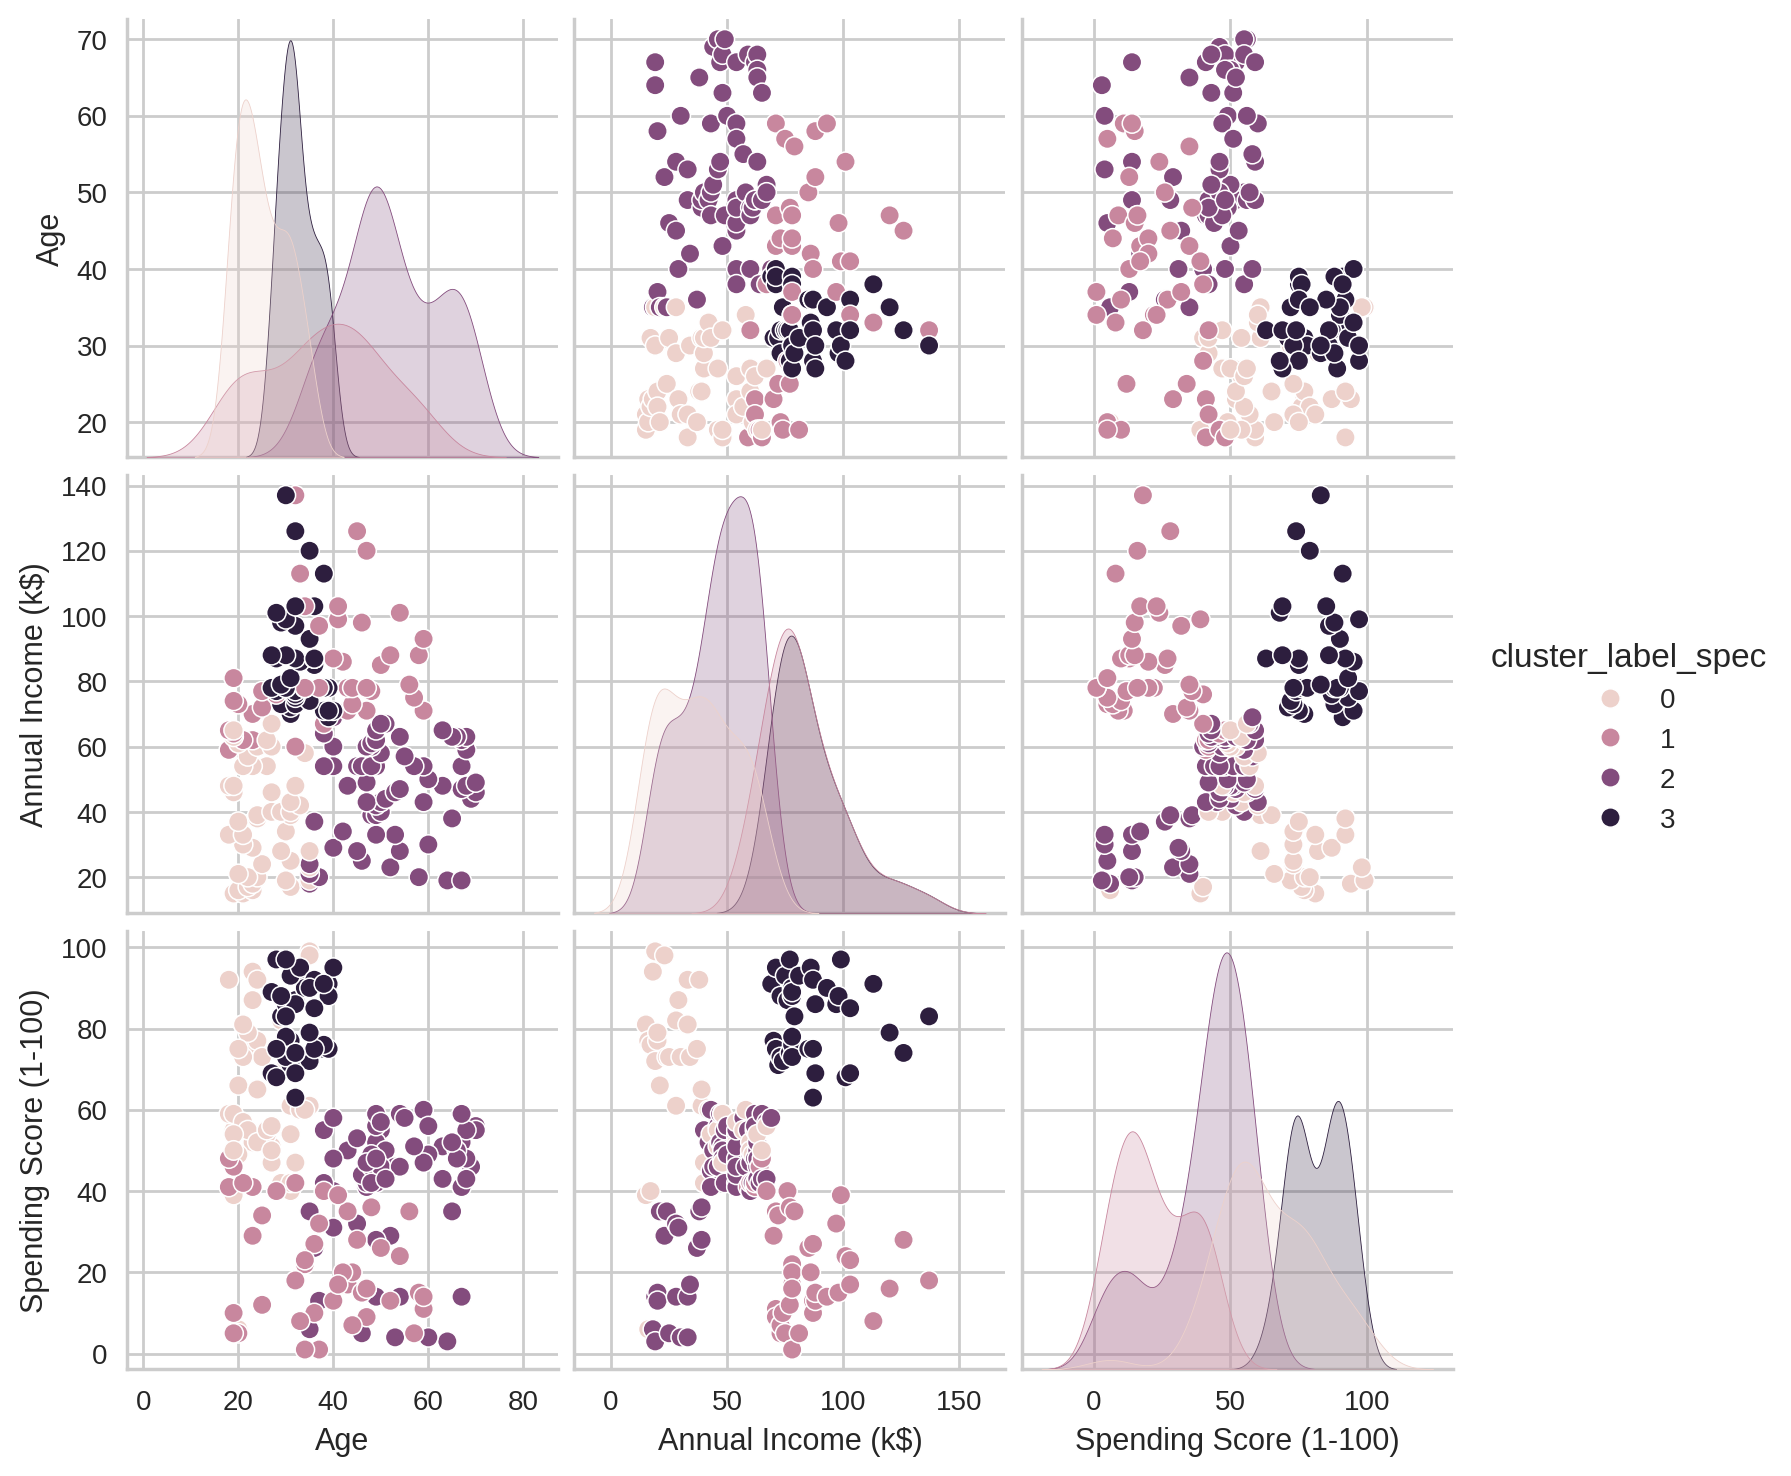

In [ ]:
spectral_model = SpectralClustering(n_clusters=4,  # Number of clusters to train.
                                    assign_labels='cluster_qr',
                                    affinity='nearest_neighbors',
                                    n_jobs=-1,
                                    n_neighbors=10,
                                    random_state=2025)

# Fit the model and get the labels
data = data.with_columns(pl.Series('cluster_label_spec',
                                   spectral_model.fit_predict(data_scaled.drop("CustomerID"))
))

# Create a pairplot using seaborn
sns.pairplot(vars=features_to_transform, # Variable names
             hue='cluster_label_spec',        # How to colour the points. Use cluster labels
             data=data.to_pandas()                   # What data to use
            )

plt.show()

11. Using the clusters from Q10, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster and compare it with your K-Means results.

In [ ]:
data.group_by(by='cluster_label_spec').agg(pl.col(features_to_transform).mean())

by,Age,Annual Income (k$),Spending Score (1-100)
i64,f64,f64,f64
2,52.647059,46.808824,40.838235
1,37.866667,83.222222,22.4
3,32.692308,86.538462,82.128205
0,25.229167,37.6875,63.583333


**Written answer:**

1. Cluster 0 represent the youngest customers with the lowest annual income, and a comparatively high spending score.
2. Cluster 1 represents middle-aged customers with the high income and the lowest score.
3. Cluster 2 are, comparatevely, seniors with an average income and a low spending score.
3. Cluster 3 are adults in their low thirties with highest income, and the highest spending score.



12. Compare the results obtained between K-Means clustering and Spectral clustering. Comment your findings.

**Written answer:**
Both methods identified similar clusters, grouping customers as follows:

1. The youngest customers, characterized by the lowest annual income and a comparatively high spending score.
2. Middle-aged customers with a high annual income and a low spending score.
3. Adults in their early thirties with high income and high spending score.
4. Seniors with an average income and a low spending score.